In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import xgboost as xgb


Since the model was built with hyperparameter tuning, we do not need to tune the model again.
we can use the best model to predict the test data and evaluate the model.

In [5]:
xgb_model = joblib.load("../outputs/models/best_xgboost_model.pkl")


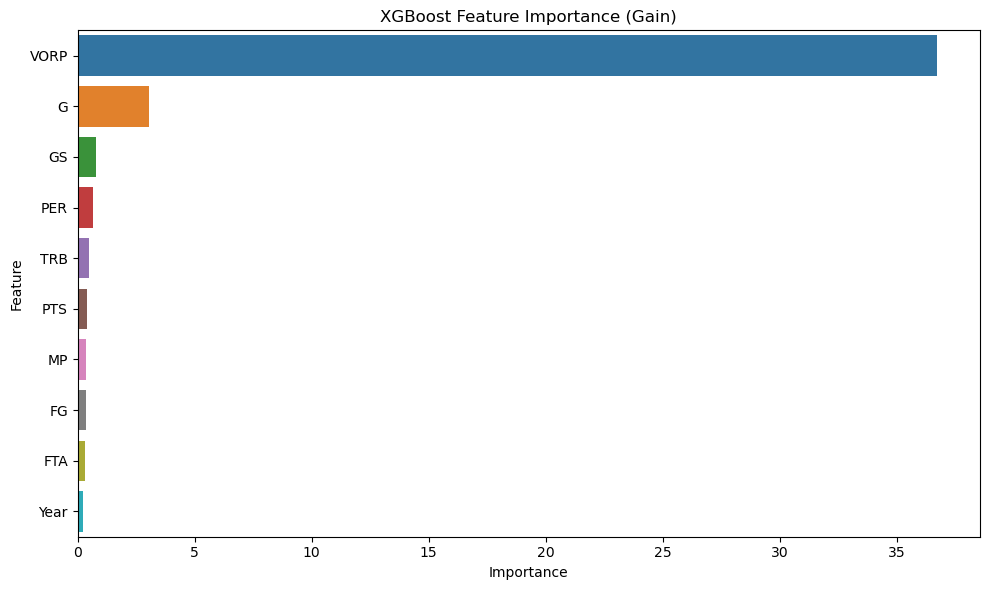

In [ ]:
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Forecasting win shares for 2026 

In [7]:
Nba2025 = pd.read_csv('/Users/omardukureh12/Capstone_377/data/processed/NBA2025.csv')

mean_vals = Nba2025.mean(numeric_only=True)
Nba2025.fillna(mean_vals, inplace=True)



In [8]:
features = [ 'VORP', 'FG',  'TRB',  'PER',  'FTA', 'MP', 'GS', 'PTS', 'G', 'Year']
target = ['WS']

In [9]:
df_2025 = Nba2025[Nba2025["Year"] == 2025].copy()
X_2026 = df_2025[features].copy()
X_2026["Year"] = 2026  # simulate the next season+= 1 

In [10]:
y_pred = xgb_model.predict(X_2026)

In [11]:
players_2026 = df_2025[["Player"]].copy()
players_2026["Year"] = 2026
players_2026["WS_pred"] = y_pred

In [12]:
players_2026.to_csv('2026_forecast.csv')

# Projecting Team wins based on player win shares

In [13]:
Players_and_Team = pd.merge(
    players_2026, 
    Nba2025[['Player', 'Team']],  # include 'Player' explicitly for clarity
    on='Player', 
    how='left'
)

In [19]:
Players_and_Team

,Player,Year,WS_pred,Team
0,Shai Gilgeous-Alexander,2026,14.265775,OKC
1,Giannis Antetokounmpo,2026,10.740507,MIL
2,Nikola Jokić,2026,15.048607,DEN
3,Luka Dončić,2026,7.444863,LAL
4,Anthony Edwards,2026,8.418916,MIN
...,...,...,...,...
564,Riley Minix,2026,-0.073764,SAS
565,Jahlil Okafor,2026,0.061195,IND
566,Zyon Pullin,2026,-0.076057,MEM
567,Isaiah Stevens,2026,-0.074258,MIA


In [20]:


Players_and_Team.loc[Players_and_Team["Team"] == "BKN", "Team"] = "BRK"


In [21]:
Teams = ["OKC", "LAL", "LAC", "GSW", "MIA", "BOS", "BRK", "PHI", "TOR", "MIL", "IND", "CHI", "DET", 
         "ATL", "CHO", "NYK", "ORL", "WAS", "UTA", "DEN", "MIN", "POR", "DAL", "HOU", "MEM", 
         "NOP", "SAS", "SAC", "PHO", "LAC", "GSW"] #create new dataframe with the teams
df_teams = pd.DataFrame(Teams, columns = ["Team"])
df_teams


,Team
0,OKC
1,LAL
2,LAC
3,GSW
4,MIA
5,BOS
6,BRK
7,PHI
8,TOR
9,MIL


In [ ]:
# Use the full dataframe, not just the Player column
df_players = Players_and_Team.copy()

# Step 1: Group the predicted win shares by team
team_win_shares = df_players.groupby("Team")["WS_pred"].sum().reset_index()

# Step 2: Rename column for clarity
team_win_shares.columns = ["Team", "Total Wins"]

# Step 3: Remove duplicates in team list
df_teams_unique = df_teams.drop_duplicates().reset_index(drop=True)

# Step 4: Merge win shares into df_teams
df_teams = df_teams_unique.merge(team_win_shares, on="Team", how="left")

# Step 5: Fill any NaNs with 0 if a team had no player data
df_teams["Total Wins"] = df_teams["Total Winse"].fillna(0)

# Final result
print(df_teams)

KeyError: 'Total Win Share'